In [1]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Load EfficientNetB4 Pretrained Model
base_model = EfficientNetB4(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base layers to speed up training

# Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)  # Regularization
output = Dense(1, activation="sigmoid")(x)  # Binary classification

# Define Final Model
model = Model(inputs=base_model.input, outputs=output)

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# Callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Model Summary
model.summary()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_directory(r"C:\Users\jaiag\Desktop\Postulate\celebdf+ff++\train", target_size=(224, 224), batch_size=32, class_mode="binary")

Found 11633 images belonging to 2 classes.


In [10]:
val_generator = val_datagen.flow_from_directory(r"C:\Users\jaiag\Desktop\Postulate\celebdf+ff++\validation", target_size=(224, 224), batch_size=32, class_mode="binary")

Found 2400 images belonging to 2 classes.


In [11]:
# Train the Model (Fast Training Phase)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

c:\Users\jaiag\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 763ms/step - accuracy: 0.4976 - loss: 1.1398
Epoch 1: val_loss improved from inf to 0.69311, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 340s 903ms/step - accuracy: 0.4976 - loss: 1.1394 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.5106 - loss: 0.7664
Epoch 2: val_loss improved from 0.69311 to 0.69277, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 280s 769ms/step - accuracy: 0.5106 - loss: 0.7664 - val_accuracy: 0.5271 - val_loss: 0.6928
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.4990 - loss: 0.7111
Epoch 3: val_loss improved from 0.69277 to 0.69170, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 281s 771ms/step - accuracy: 0.4990 - loss: 0.7111 - val_accuracy: 0.5400 - val_loss: 0.6917
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.5124 - loss: 0.7015
Epoch 4: val_loss did not improve from 0.69170
364/364 ━━━━━━━━━━━━━━━━━━━━ 287s 787ms/step - accuracy: 0.5124 - loss: 0.7015 - val_accuracy: 0.5033 - val_loss: 0.6929
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.5165 - loss: 0.6979
Epoch 5: val_loss did not improve from 0.69170
364/364 ━━━━━━━━━━━━━━━━━━━━ 278s 764ms/step - accuracy: 0.5165 - loss: 0.6979 - val_accuracy: 0.5000 - val_loss: 0.6934
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.5010 - loss: 0.6975
Epoch 6: val_loss did not improve from 0.69170
364/364 ━━━━━━━━━━━━━━━━━━━━ 285s 783ms/step - accuracy: 0.5010 - loss: 0.6975 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 3.


In [13]:
# Fine-Tuning: Unfreeze Some Layers After 5 Epochs
base_model.trainable = True  # Unfreeze for fine-tuning
for layer in base_model.layers[:200]:  # Freeze first 200 layers, fine-tune last ones
    layer.trainable = False

# Compile Again with Lower LR
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

# Train for a Few More Epochs with Callbacks
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5366 - loss: 0.6931
Epoch 1: val_loss improved from 0.69170 to 0.65149, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.5366 - loss: 0.6930 - val_accuracy: 0.6350 - val_loss: 0.6515
Epoch 2/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5910 - loss: 0.6661
Epoch 2: val_loss improved from 0.65149 to 0.59250, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 660s 2s/step - accuracy: 0.5910 - loss: 0.6660 - val_accuracy: 0.6879 - val_loss: 0.5925
Epoch 3/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6248 - loss: 0.6479
Epoch 3: val_loss did not improve from 0.59250
364/364 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.6248 - loss: 0.6478 - val_accuracy: 0.7042 - val_loss: 0.6660
Epoch 4/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6487 - loss: 0.6209
Epoch 4: val_loss did not improve from 0.59250
364/364 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.6487 - loss: 0.6209 - val_accuracy: 0.7088 - val_loss: 0.6790
Epoch 5/5
364/364 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6773 - loss: 0.6031
Epoch 5: val_loss improved from 0.59250 to 0.54425, saving model to best_model.h5


364/364 ━━━━━━━━━━━━━━━━━━━━ 680s 2s/step - accuracy: 0.6773 - loss: 0.6031 - val_accuracy: 0.7142 - val_loss: 0.5442
Restoring model weights from the end of the best epoch: 5.


In [15]:
from matplotlib import pyplot as plt

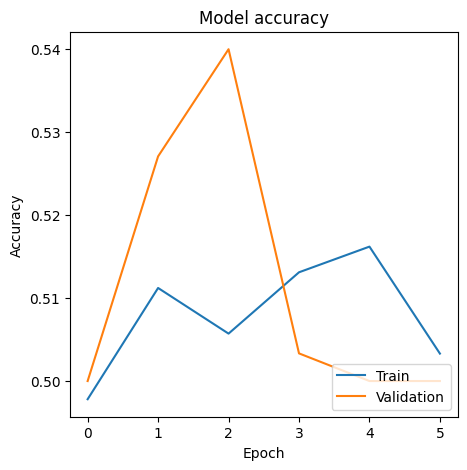

In [25]:
# FIRST
# Plot training & validation accuracy values
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

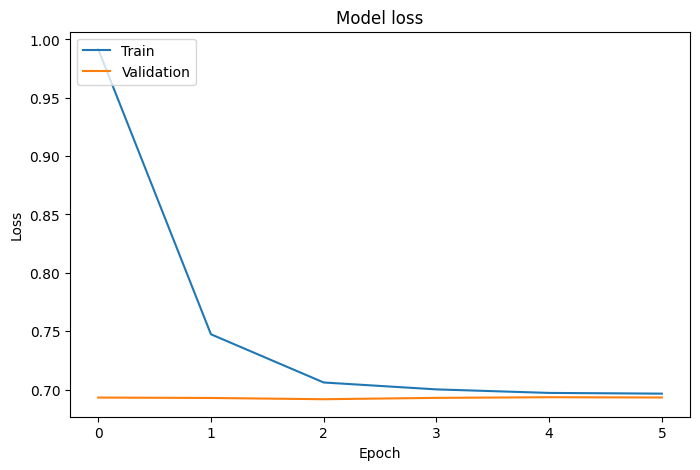

In [26]:
# FIRST
# Plot training & validation loss values
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from mtcnn import MTCNN

In [2]:
# Load model
model = load_model("best_model.h5")

In [3]:
# Function to extract frames from video provided by user
def extract_frames(video_path, frame_interval=5):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = 0
    ret, frame = cap.read()
    while ret:
        if frame_count % frame_interval == 0:
            detector = MTCNN()
            faces = detector.detect_faces(frame)
            if len(faces) != 0:
                x, y, width, height = faces[0]['box']
                frame = frame[y:y + height, x:x + width]
                frame = cv2.resize(frame, (128, 128))
                frame = frame / 255.0  # Normalize
                frame = frame.astype(np.float32)
                frames.append(frame)
                print(frame_count)
        ret, frame = cap.read()
        frame_count += 1

    cap.release()
    print(f"Total Frames: {len(frames)}")
    return np.array(frames)

In [4]:
def predict_video(video_path):
    frames = extract_frames(video_path)
    predictions = model.predict(frames , batch_size=2)  # Get predictions for each frame

    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")

    # If avg_prediction > 0.5, classify as Fake; else, Real
    video_label = "Fake" if avg_prediction > 0.5 else "Real"
    print(f"Final Video Classification: {video_label}")

In [18]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    # img = cv2.resize(img, (224, 224))  # Resize
    # img = img / 255.0  # Normalize (0-1)
    # img = img.astype(np.float32)

    # Add a batch dimension
    # img = np.expand_dims(img, axis=0)


    predictions = model.predict(img)
    avg_prediction = np.mean(predictions)  # Average across all frames
    print(f"Average Prediction Score: {avg_prediction:.4f}")
    print(f"Final Classification: {"Fake" if avg_prediction > 0.5 else "Real"}")

In [ ]:
model.predict(img)